# Wavelets with Scipy

To start off, we will perform the continuous wavelet transform on the original signals (the time series solutions to the Lorenz attractors) and examine the results.

In [1]:
%load_ext base16_mplrc
%base16_mplrc dark bespin

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.
Setting plotting theme to bespin-dark. Palette available in b16_colors


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.ndimage import gaussian_filter1d
from scipy import signal

import seaborn as sns
from seaborn import xkcd_palette as xkcd
blue, red, green = xkcd(['cornflower','bright red','bluish green'])

In [3]:
%matplotlib inline

In [4]:
from lorenz_rhs import lorenz, get_lorenz_solution

In [5]:
in_0 = [5.0, 5.0, 5.0]
t_max = 100
dt = 0.01
t_steps = t_max/dt
t, [solx, soly, solz] = get_lorenz_solution(in_0, t_max, t_steps, 
                                            (10.0, 8/3, 28))

In [6]:
def wavelet_column(t, sol, title, z=8):
    n = len(sol)
    k = np.arange(n)
    y = np.fft.fft(sol)
    
    widths = np.arange(1, 2**z - 1)
    
    # signal.ricker is the Mexican hat wavelet
    cwtmatr = signal.cwt(sol, signal.ricker, widths)
    
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)
    col = ax.imshow(cwtmatr, extent=[0, n, 2**z - 1, 1], cmap='PRGn', aspect='auto',
              vmax=abs(cwtmatr).max()/1.5, vmin=-abs(cwtmatr).max()/1.5)
    ax.set_title("Wavelet: " + title)
    ax.set_ylabel('Wavelet Bandwidth')
    
    plt.colorbar(col)
    
    return cwtmatr

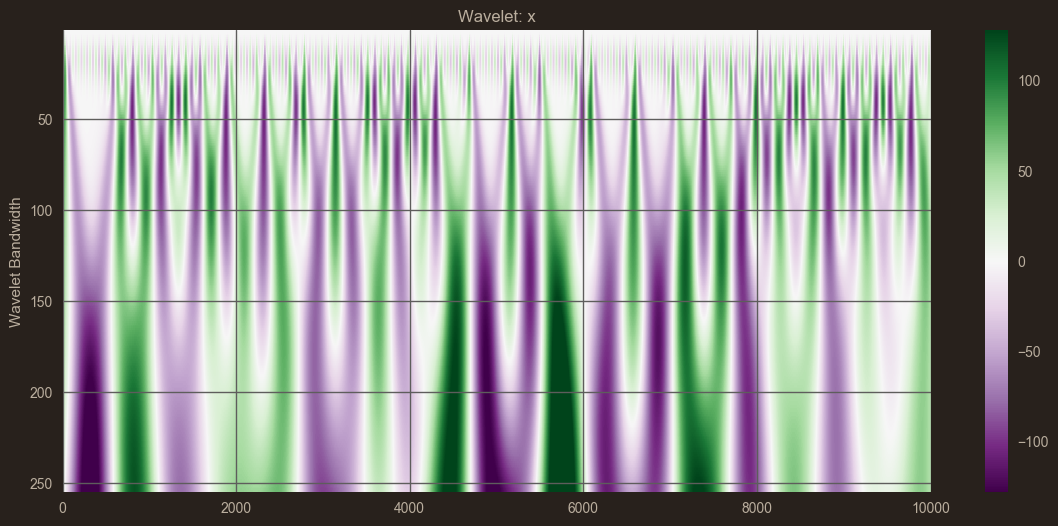

In [7]:
cwtmatx = wavelet_column(t, solx, "x", 8)

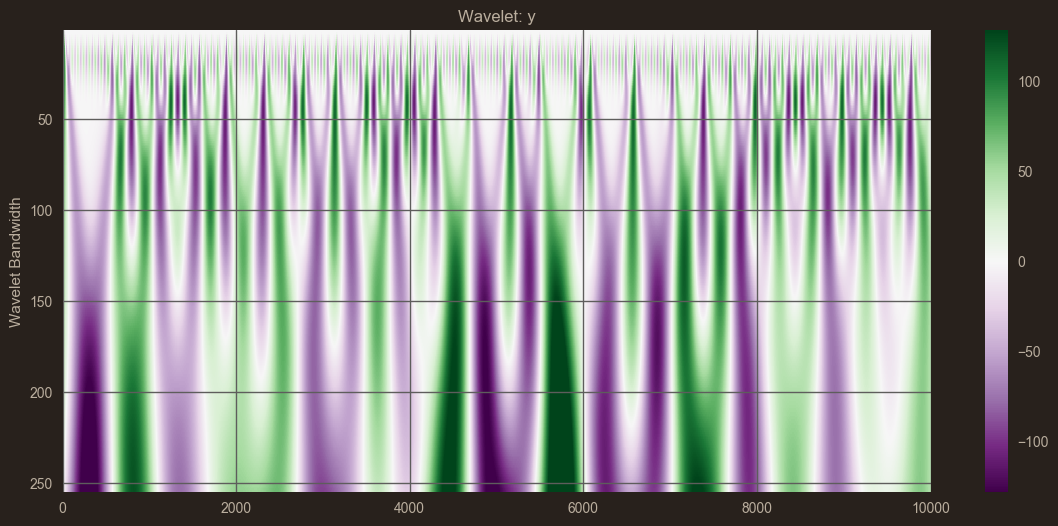

In [8]:
cwtmaty = wavelet_column(t, soly, "y", 8)

The wavelet coefficient arrays for both the x and y time series are shown in the two plots above. These show, at the top, a very small wavelet bandwidth (meaning the window of data being examined is small). Groupings of purple or green at the top of the image indicate a small scale grouping of frequency behavior. As the bandwidth gets larger (moving down the y axis), the bands of color indicate the strongest trends as the wavelet gets wider. For example, a large purple band means that the overall signal generally has a large frequency in the negative direction. 

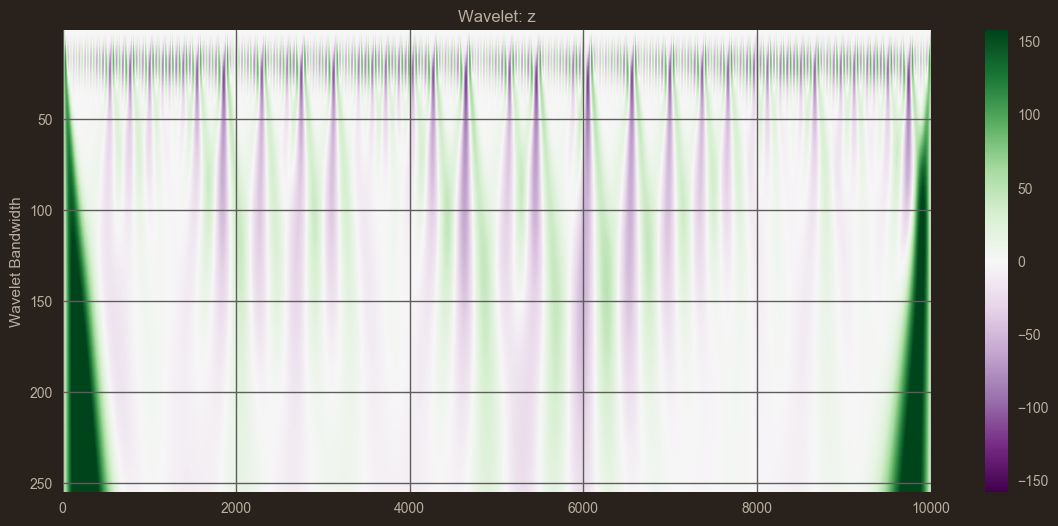

In [9]:
cwtmatz = wavelet_column(t, solz, "z")

In [10]:
def multiple_wavelets(ts, solutions, titles, z=8):
    
    if(len(ts)!=4 or len(solutions)!=4):
        raise Exception("Error: need four times and four solutions")
    
    fig = plt.figure(figsize=(14,8))
    
    axes = [fig.add_subplot(2,2,i+1) for i in range(4)]
    
    for ax, t, sol, title in zip(axes, ts, solutions, titles):
    
        n = len(sol)
        k = np.arange(n)
        y = np.fft.fft(sol)
        
        widths = np.arange(1, 2**z - 1)
        cwtmatr = signal.cwt(sol, signal.ricker, widths)
        
        col = ax.imshow(cwtmatr, extent=[0, n, 2**z - 1, 1], cmap='PRGn', aspect='auto',
                        vmax=abs(cwtmatr).max()/1.5, vmin=-abs(cwtmatr).max()/1.5)
        
        ax.set_title(title)
        ax.set_ylabel('Wavelet Bandwidth')
        
        plt.colorbar(col, ax=ax)

    return cwtmatr

In [11]:
in_0 = [5.0, 5.0, 5.0]
t_max = 100
dt = 0.01
t_steps = t_max/dt
rz = list(np.linspace(25,40,4))

ts = []
sols = []

for r in rz:
    t, sol = get_lorenz_solution(in_0, t_max, t_steps, (10.0, 8/3, r))
    ts.append(t)
    sols.append(sol)

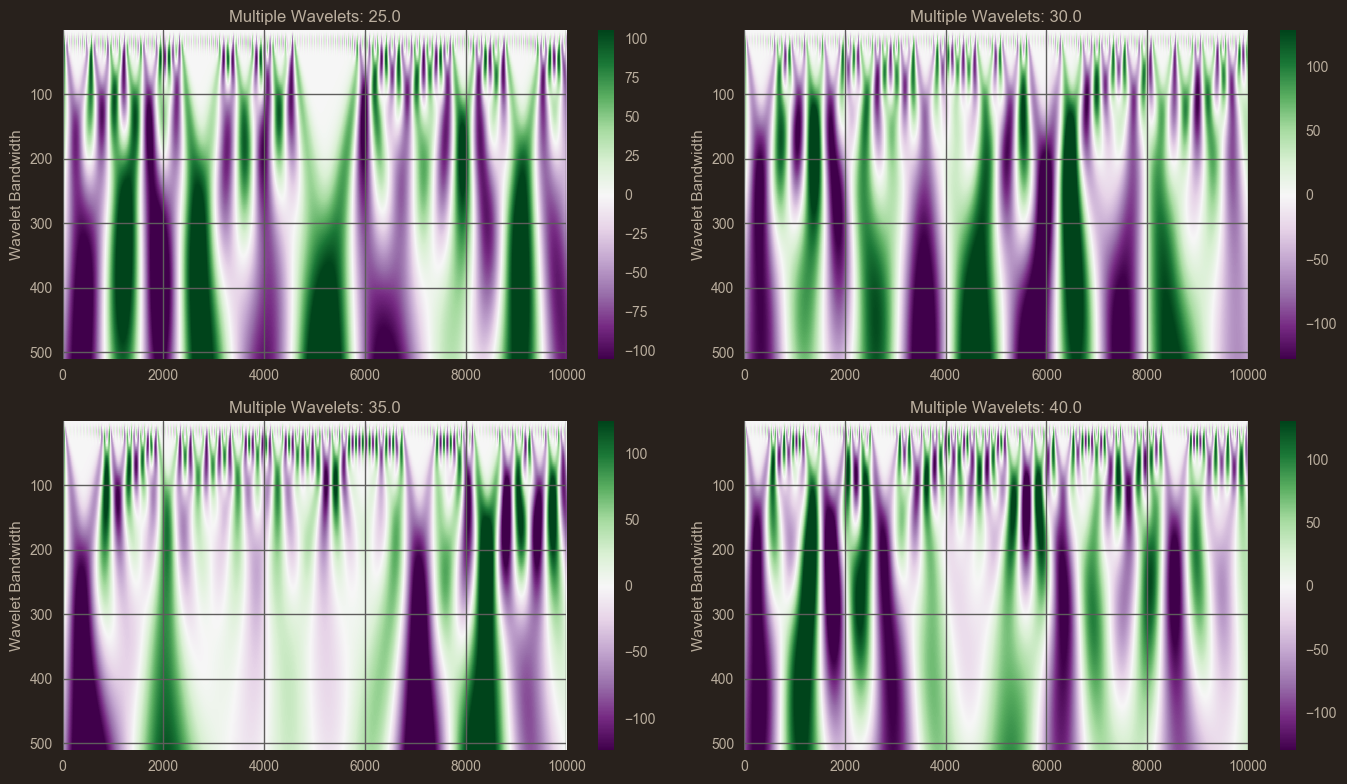

In [12]:
cw = multiple_wavelets(ts, [sol[0] for sol in sols], ["Multiple Wavelets: %0.1f"%(r) for r in rz], 9)
plt.tight_layout()

In [13]:
from ipywidgets import interact, interactive, fixed

In [14]:
def make_wavelet_column(sigma=10.0, b=8.0/3.0, r=30, z=8):
    
    in_0 = [5.0, 5.0, 5.0]
    t_max = 100
    dt = 0.01
    t_steps = t_max/dt
    t, [solx, soly, solz] = get_lorenz_solution(in_0, t_max, t_steps, (sigma, b, r))
    
    sol = solx
    n = len(sol)
    k = np.arange(n)
    y = np.fft.fft(sol)
    
    widths = np.arange(1, 2**z - 1)
    
    cwtmatr = signal.cwt(sol, signal.ricker, widths)
    
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)
    col = ax.imshow(cwtmatr, extent=[0, n, 2**z - 1, 1], cmap='cool', aspect='auto',
              vmax=abs(cwtmatr).max()/1.5, vmin=-abs(cwtmatr).max()/1.5)
    ax.set_title("Wavelet")
    ax.set_ylabel('Wavelet Bandwidth')
    
    plt.colorbar(col)
    
    #return cwtmatr

In [15]:
sigmalims = (5.0, 20.0, 1.0)
rlims = (25.0, 40.0, 5.0)
z = (7,9,1)
w = interactive(make_wavelet_column, sigma=sigmalims, z=9)
display(w)

interactive(children=(FloatSlider(value=10.0, description='sigma', max=20.0, min=5.0, step=1.0), FloatSlider(value=2.6666666666666665, description='b', max=8.0, min=-2.6666666666666665), IntSlider(value=30, description='r', max=90, min=-30), IntSlider(value=9, description='z', max=27, min=-9), Output()), _dom_classes=('widget-interact',))

In [16]:
# Pre-compute a series of wavelets for a given signal,
# to make interaction faster.

# Sigma will be the slider variable
sigma_start  = 10.0000
sigma_end    = 10.0001
sigma_steps  = 50
sigma_ds     = (sigma_end-sigma_start)/sigma_steps
all_sigmas   = np.linspace(sigma_start, sigma_end, sigma_steps)
all_solns    = []
all_wavelets = []

in_0 = [5.0, 5.0, 5.0]
t_max = 100
dt = 0.01
t_steps = t_max/dt
b = 8/3
r = 28
z = 8

for sigma in all_sigmas:
    t, [solx, soly, solz] = get_lorenz_solution(in_0, t_max, t_steps, (sigma, b, r))
    sol = solx
    n = len(sol)
    k = np.arange(n)
    y = np.fft.fft(sol)
    widths = np.arange(1, 2**z - 1)
    cwtmat = signal.cwt(sol, signal.ricker, widths)
    all_wavelets.append(cwtmat)

In [17]:
def make_wavelet_sigma(ix):
    cwtmat = all_wavelets[ix]    
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)
    col = ax.imshow(cwtmat, extent=[0, n, 2**z - 1, 1], 
                    cmap='cool', aspect='auto',
                    vmax=abs(cwtmat).max()/1.5, 
                    vmin=-abs(cwtmat).max()/1.5)
    
    plt.colorbar(col)
    
    ax.set_title("Wavelet")
    ax.set_ylabel('Wavelet Bandwidth')

In [18]:
#sigma_slider = (sigma_start, sigma_end, 1.0)
ix_slider = (0,sigma_steps,1)
w = interactive(make_wavelet_sigma, ix=ix_slider)
display(w)

interactive(children=(IntSlider(value=25, description='ix', max=50), Output()), _dom_classes=('widget-interact',))

Just a little bit more text....